In [96]:
import os
import time
import math
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Tesla stock data load

> 1년의 기간동안 테슬라의 주가가 기록된 테슬라 주식 데이터를 읽은 후 메모리에 할당한다.<br>
> 시계열 분석 및 학습을 위해 Date(기간)을 index으로 활용한다.

In [7]:
dataset_filepath = os.getenv('HOME') + '/aiffel/Exploration/ex_Data/ex14/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

print(df)
print("주식 데이터 기간(일봉) : ", len(df))

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-11-18   448.350006   496.000000   443.500000   486.640015   486.640015   
2020-11-19   492.000000   508.609985   487.570007   499.269989   499.269989   
2020-11-20   497.989990   502.500000   489.059998   489.609985   489.609985   
2020-11-23   503.500000   526.000000   501.790009   521.849976   521.849976   
2020-11-24   540.400024   559.989990   526.200012   555.380005   555.380005   
...                 ...          ...          ...          ...          ...   
2021-11-11  1102.770020  1104.969971  1054.680054  1063.510010  1063.510010   
2021-11-12  1047.500000  1054.500000  1019.200012  1033.420044  1033.420044   
2021-11-15  1017.630005  1031.979980   978.599976  1013.390015  1013.390015   
2021-11-16  1003.309998  1057.199951  1002.179993  1054.729980  1054.729980   
2021-11-17  1063.510010  1119.640015  1055.500000  1

> 불러온 데이터를 확인한 결과 아래와 같은 정보를 획득했다.<br>
> 1. Date(기간), Open(시작가), High(고가), Low(저가), Close(종가), Adj Close(장외 종가), Volume(거래량)으로, 총 7가지 정보를 가지고 있다.
> 2. Yahoo Finance에서 제공한 테슬라 주식 데이터의 기간은 252일이다.

> 주식 예측 모델 학습에는 Date(기간)과 Close(종가만 활용할 것이므로, Close 컬럼만 추출하여 별도의 변수로 메모리를 할당한다.

In [8]:
tsla_df = df['Close']
print(tsla_df)

Date
2020-11-18     486.640015
2020-11-19     499.269989
2020-11-20     489.609985
2020-11-23     521.849976
2020-11-24     555.380005
                 ...     
2021-11-11    1063.510010
2021-11-12    1033.420044
2021-11-15    1013.390015
2021-11-16    1054.729980
2021-11-17    1089.010010
Name: Close, Length: 252, dtype: float64


# 2. Data EDA

> 모델 구성을 위해 데이터를 목적에 맞게 가공할 수 있도록, 데이터의 형태를 분석하는 과정을 진행한다.

## 2.1 Check missing values

> 불러온 데이터에 결측치가 있는지 확인하는 작업을 수행한다.

In [13]:
x = tsla_df.value_counts().reset_index()

<AxesSubplot:>

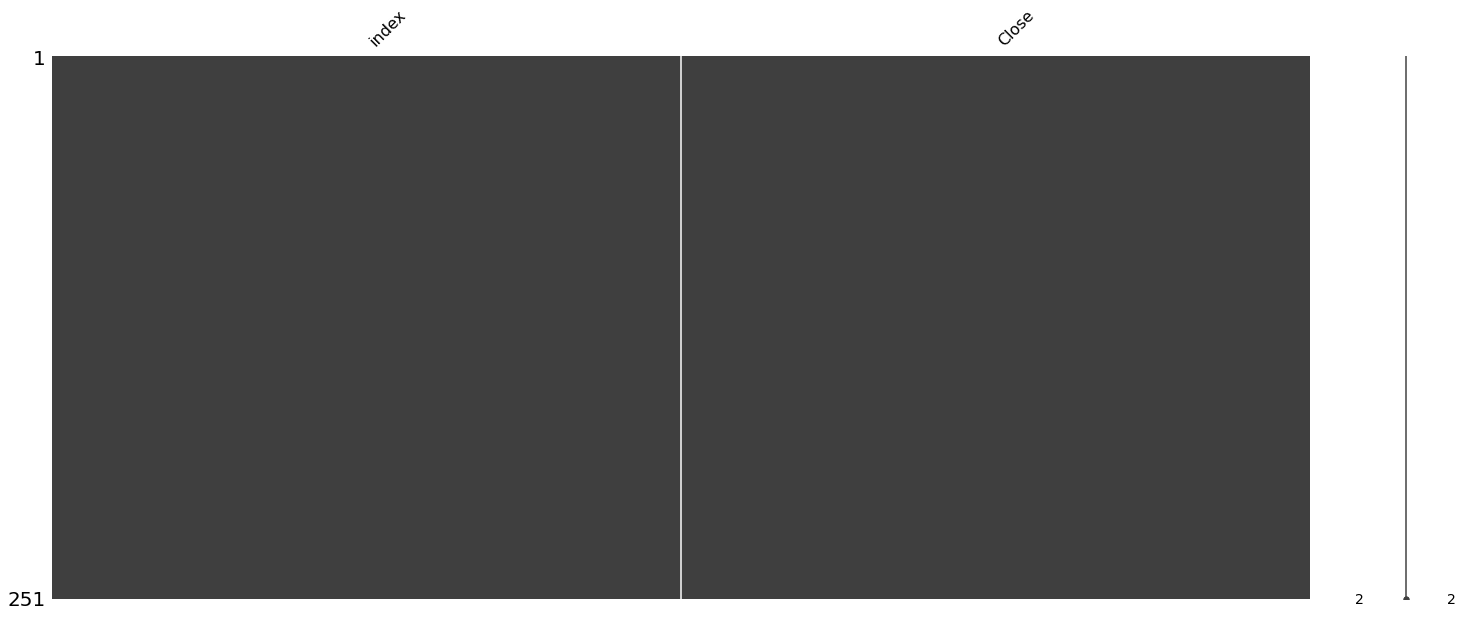

In [14]:
msno.matrix(x)

<AxesSubplot:>

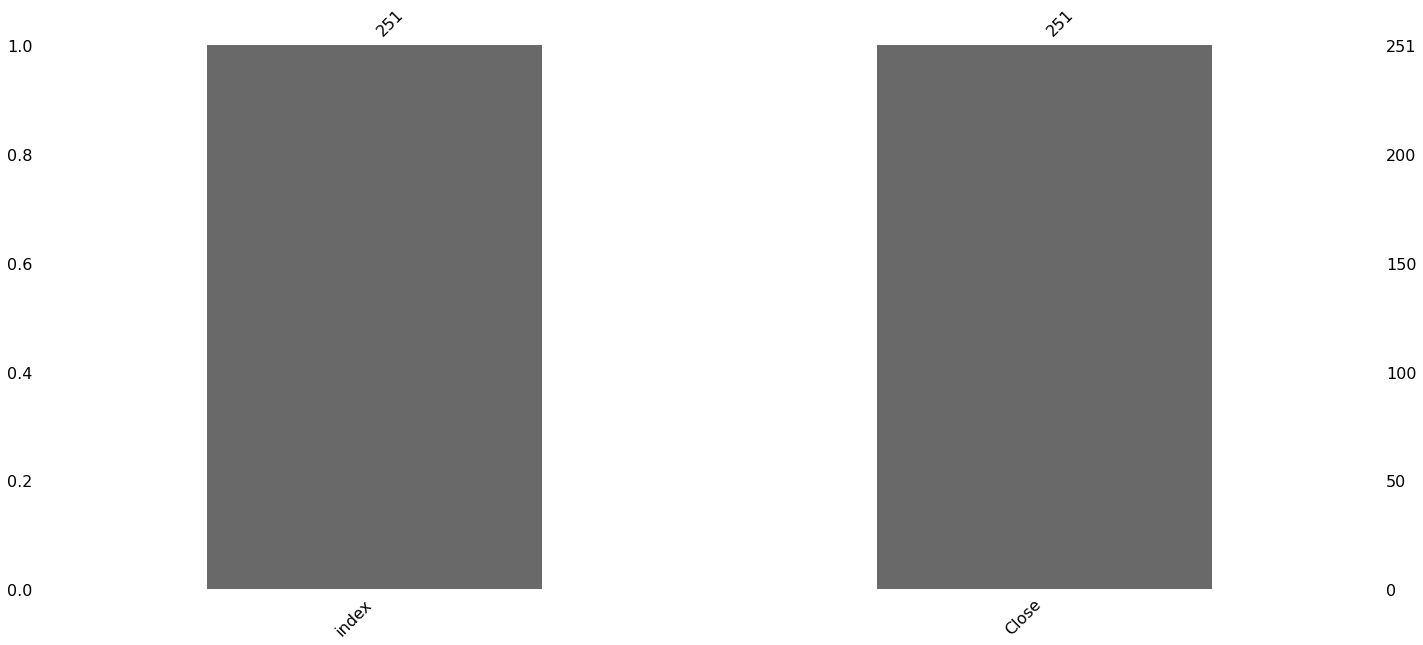

In [12]:
msno.bar(x)

> 테슬라 주식 데이터를 시각적, 수치적 분석을 진행한 결과 결측치가 확인되지 않았다.

## 2.2 Processing as a Sationary Time Series

> Sationary한 시계열로 가공하여, 이동 평균을 제거하고, 함수간 이동 평균을 구하는 차분을 진행한다.<br>
> 이동 평균을 제거함으로써, 데이터의 추세를 상쇄하고, 차분 과정을 통해 계절성(일정 패턴)을 상쇄하는 효과를 얻을 수 있다.<br>
> 위 효과를 얻기 위하여, 테슬라 주식 데이터를 로그 함수로 변환하는 과정을 수행한다.

In [20]:
tsla_df_log = np.log(tsla_df)
print(tsla_df_log)

Date
2020-11-18    6.187525
2020-11-19    6.213147
2020-11-20    6.193609
2020-11-23    6.257380
2020-11-24    6.319653
                ...   
2021-11-11    6.969330
2021-11-12    6.940629
2021-11-15    6.921056
2021-11-16    6.961040
2021-11-17    6.993024
Name: Close, Length: 252, dtype: float64


## 2.3 Time Series Stability Analysis

> 시계열 데이터는 시간의 추이와 관계없이 평균, 분산, 자기공분산이 일정해야한다.<br>
> 이에, 정성적, 정량적, 시계열 분해를 통해 메모리에 할당된 데이터셋의 안정성을 확인하는 과정을 진행한다.

### 2.3.1 정성적 그래프 분석

> 시계열 데이터의 안정석을 확인하기 위해, 정성적 분석 기법을 활용했을 때, 결과를 확인하는 작업을 진행한다.<br>
> 원본과 이동평균 시계열, 이동표준편차 시계열 3가지를 비교 분석한다.

In [21]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

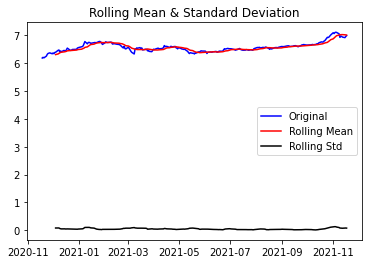

In [25]:
plot_rolling_statistics(tsla_df_log, window=12)

> 2020년 11월 부터 2021년 11월까지의 시계열 데이터를 정석적으로 분석했을 때,<br>
> Move average(MA)가 원본과 크게 다르지 않고, 이동표준편차도 크지 않음을 확인할 수 있다.<br>
> 이로써, 통계적 특정의 변화가 없고, 시간과 무관하게 일정한 값을 도출하는 안정적인 모습을 확인할 수 있다.

### 2.3.2 정량적 분석 Augmented Dicky-Fuller Test

> 시계열 데이터의 안정성 여부 확인을 위해 Augmented Dickey-Fuller Test 통계 기법을 활용하여 안정성 테스트 진행과정과 결과를 기술한다.<br>
> 만약(if), "테슬라 주식 시계열 데이터가 안정적이지 않다" 라는 귀무가설을 전제로 통계적 가설을 검증한다.<br>
> 이때, 귀무 가설이 False일 경우, 명제의 '역'에 해당하는 "이 시계열 데이터는 안정적이라"라는 대립가설을 채택한다.

In [26]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [27]:
augmented_dickey_fuller_test(tsla_df_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.508334
p-value                          0.529384
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


> "주어진 시계열 데이터가 안정적이지 않다"는 귀무가설의 수치인 p-value는 0.529로, 중립 값인 모호안 결과를 보여주었다.<br>
> 위 과정에서 로그함수로 이미 1번 시계열을 가공하여 안정성을 확보했음에도 위와같은 결과를 보여주었다.<br>
> 이로써, 귀무가설도, 대립가설도 모두 입증되지 않는 모습을 보여주었다.<br>
> 그래도, 선택한다면 0.529는 0보다 1에 가깝기 때문에 귀무가설을 선택할 것 같다.<br>
> PS. 사실 테슬라 주식은 급등과 급락이 심한 종목이라 시계열이 안정적이지 않다는 의견에 동의한다.

### 2.3.3 시계열 분해 Time Series Decomposition

> 위 Augmented Dicky-Fuller Test 과정을 통해 테슬라 주식 데이터가 안정적이지 않을 가능성이 있음을 확인했다.<br>
> 이러한 불확실성을 최대한 제거하기 위해, Time Series Decomposition 기법을 활용하여 다시 한번 안정성을 확보하는 작업을 진행한다.

> statsmodels 라이브러리의 seasonal_decompose 함수를 활용하여 시계열 내의  trend, seasonality, residual을 분리한다.

In [31]:
decomposition = seasonal_decompose(tsla_df_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

> 아래 표는 로그함수 과정을 거친 테슬라 주식 시계열 데이터이다.

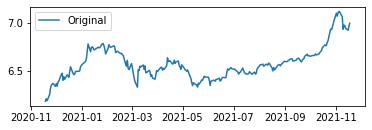

In [39]:
plt.subplot(211)
plt.plot(tsla_df_log, label='Original')
plt.legend(loc='best')

> 아래 표는 로그함수 과정을 거친 테슬라 주식 시계열 데이터의 trend를 분리한 모습이다.<br>
> 원본 데이터의 변화의 큰 움직임(추세)에 맞춰 잘 표기한 모습을 보여주었다.

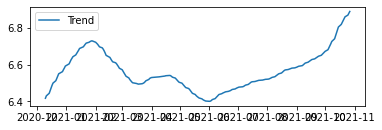

In [40]:
plt.subplot(212)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

> 아래 표는 로그함수 과정을 거친 테슬라 주식 시계열 데이터의 seasonal를 분리한 모습이다.<br>
> 원본 데이터의 변화를 일정한 패턴으로 움직이는 모습을 잘 표시한 모습을 보여주었다.

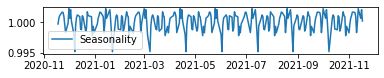

In [46]:
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

> 아래 표는 로그함수 과정을 거친 테슬라 주식 시계열 데이터의 residual을 분리한 모습이다.<br>
>  원본 데이터의 변화의 작은 움직임(residual)에 맞춰 잘 표기한 모습을 보여주었다.

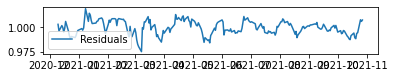

In [49]:
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

In [35]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

### 2.3.4 Residual 안정성 확인

> Residual의 기본값은 추세값(trend)에 비해 변동성이 매우 높다.<br>
> 이에, "Residual 시계열 데이터는 안정적이지 않다."라는 귀무가설을 전제로 통계적 가설을 검증한다.<br>
> 이때, 귀무 가설이 False일 경우, 명제의 '역'에 해당하는 "이 시계열 데이터는 안정적이라"라는 대립가설을 채택한다.

In [50]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.556915
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


> "Residual의 시계열 데이터가 안정적이지 않다"는 귀무가설의 수치인 p-value는 0.000002로, 0에 매우 가까운 결과를 보여주었다.<br>
> 이는, 귀무가설이 False임이 입증되었으며, 이에 "Residual의 시계열 데이터가 안정적이다"라는 대립가설을 채택한다.

# 3. Create train, test dataset

> 위 2장을 통해, residual값이 예측력 있는 안정적인 시계열 데이터임을 확인했다.<br>
> ARIMA. 이하, 자기회귀누적이동평균 (Autoregressive integrated moving average)는 탄탄한 통계학 이론적 기반을 바탕으로 보편적으로 사용되는 모델이다.<br>
> 위 데이터와 ARIMA 모델을 활용하여 주식 가격 예측 모델을 생성한다.<br>
> 이를 위해, 학습용, 테스트용 데이터 세트를 생성하는 공정을 진행한다.

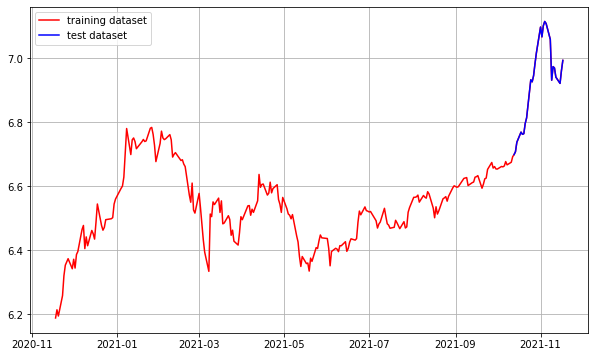

In [52]:
train_data, test_data = tsla_df_log[:int(len(tsla_df_log)*0.9)], tsla_df_log[int(len(tsla_df_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(tsla_df_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

> 원본 차트 데이터에 맞게 데이터셋이 구성되었음을 확인할 수 있다.<br>
> 내 주식도 저렇게 올라갔으면 좋겠다.

# 4. Checking the right ARIMA parameters

> ARIMA 통계 모델이 효과적으로 예측하기 ARIMA의 parameter를 잘 설정해야 올바른 예측식을 구하고, 올바은 예측값을 출력할 수 있다.<br>
> ARIMA의 모수는 아래의 3가지이며 아래 목록과 같다<br>
> + p : 자기회귀 모형(AR)의 시차<br>
> + q : 이동평균 모형(MA)의 시차<br>
> + d : 차분누적(I) 횟수<br>

> 위 파라미터를 선택하는 방법으로, ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)가 대표적이다.<br>
> 이에, 위 방법을 활용하여 최적인 ARIMA parameter을 구하는 공정을 진행한다.

## 4.1 Check ACF for p, q

> ACF(Autocorrelation)는 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수이다.<br>
> 즉, 주어진 시계열의 현재 값이 과거값과 어떻게 상관되는지 설명하는 함수이다.<br>
> ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타낸다.<br>
> 위 함수를 활용하여 ARIMA 모델의 P, Q를 구하는 작업을 진행한다.

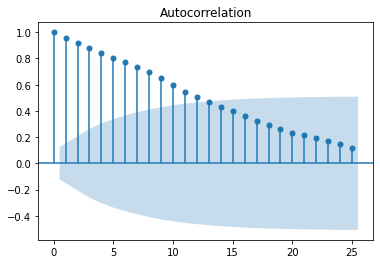

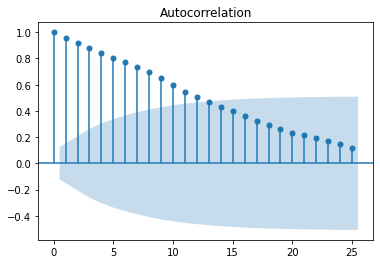

In [55]:
plot_acf(tsla_df_log)

> 현재값과 과거같이 일정하게 상관관계를 가지며 P, Q 모두 동일한 모습을 보여주었다.

## 4.2 Check PACF for p, q

> PACF(Partial Autocorrelation)는 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수이다.<br>
> k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데 특정 두 관측치가 얼마나 관련이 있는지 나타내는 척도이다.<br>
> 위 함수를 활용하여 ARIMA 모델의 P, Q를 구하는 작업을 진행한다.

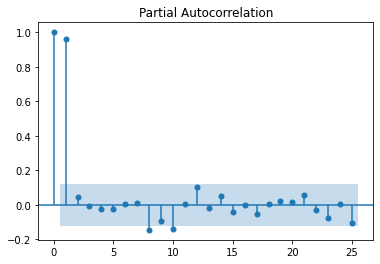

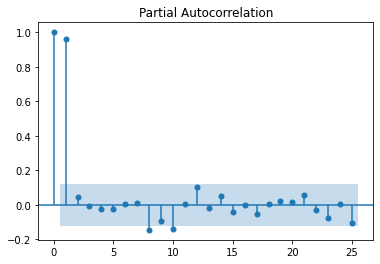

In [57]:
plot_pacf(tsla_df_log) 

> 테슬라 주식은 초기 2개월간 급등 후, 일론 머스크 트윗으로 인해 급락한 후, 10개월간 우상향하는 모습을 보여주었다.<br>
> 이에, 데이터도 초기에 급등한 2개월은 이상치를 보여주었으나, 나머지 10개월 데이터는 준수한 관련성을 보여주었다.<br>
> 위와같은 모습을 보여주며, P,Q 둘 다 동일한 모습을 보여주었다.

## 4.3 Check difference for d

> 연이은 관측값들의 차이를 계산하기 위해, difference 함수를 활용하여 시계열 관측값의 차분을 구하는 작업을 진행한다.

Results of Dickey-Fuller Test:
Test Statistic                -1.680915e+01
p-value                        1.202980e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


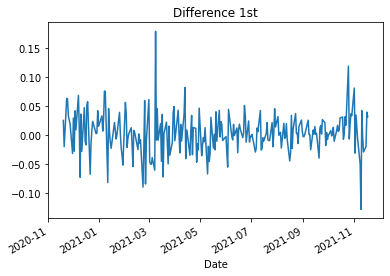

In [60]:
diff_1 = tsla_df_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

> 테슬라 주가가 급락했던 2021년 3월과, 주가가 급등한 2021년 11월의 차분 값의 변화가 큰 모습을 확인할 수 있다.

# 5. Create model and train

> 4장에서 구한 ARIMA의 파라미터를 활용하여 ARIMA 모델을 훈련하는 과정을 기술한다.

> statsmodels.tsa.arima_model 라이브러리에서 ARIMA가 구현된 객체를 제공한다.
> 3장에서 확보한 훈련용 데이터 셋을 활용하여 ARIMA를 훈련 후, 결과를 확인한다.

In [63]:
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1) 
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 449.896
Method:                       css-mle   S.D. of innovations              0.033
Date:                Thu, 18 Nov 2021   AIC                           -893.792
Time:                        05:32:39   BIC                           -883.544
Sample:                             1   HQIC                          -889.656
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0022      0.002      1.121      0.262      -0.002       0.006
ar.L1.D.Close    -0.1012      0.066     -1.527      0.127      -0.231       0.029
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

# 6. Result

> 5장의 모델 훈련 결과를 그림으로 시각화 하여 표현하면 아래 그림과 같다.

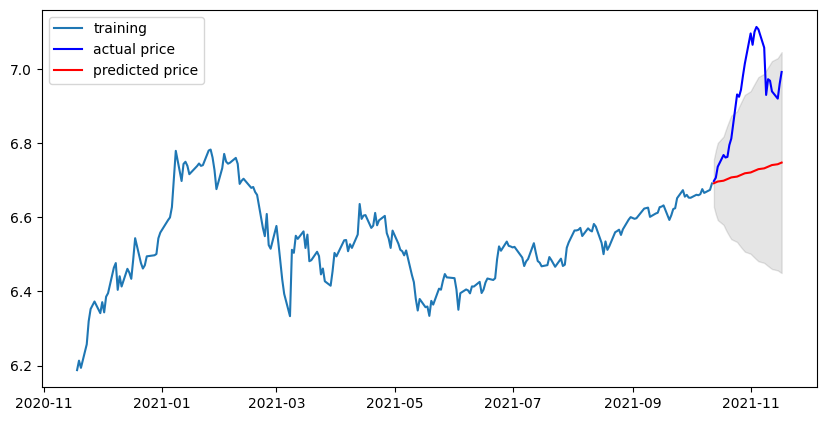

In [73]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

> 위 그래프의 MSE, MAE, RMSE, MAPE는 아래 출력과 같다.

In [74]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))

print('MSE: ', mse)
print('MAE: ', mae)
print('RMSE: ', rmse)
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  53701.73900873087
MAE:  197.79590693592976
RMSE:  231.73635668304374
MAPE: 18.04%


> 최종 MAPE의 정확률은 18.04%이나, 장기적인 관점에서는 예측을 잘 했다고 생각한다.<br>
> 위 모델은 장기 추세선(120일선, 180일선)을 기준으로 큰 추세를 바탕으로 예측하도록 설계되었기 때문이다.<br>
> 또한, 최근 주가가 모델이 예측한 상한선 바운드 범위내에 있음을 확인할 수 있다.<br>
> 테슬라의 주식은 2021년 10월 파리 기후환경 규제 협약 이후로, 친환경 전기차에 대한 기대 수요가 폭발함에 따라,<br>
> 단기적인 호재로 큰 상승을 이루었고, 또한 테슬라의 CEO 일론 머스크의 다른 사업인 SpaceX의 민간 로켓 발사 성공에 따른 추가 호재로<br>
> 상승한 급등이기 때문이다. 이러한 급등은 장기적인 관점에서 예측하도록 설계된 모델에서는 예측율이 낮을 수 밖에 없다.<br>
> 만약, 2022년 2분기까지의 주가 그래프 데이터가 있었다면, 결국 모델이 예측한 추세선에 맞는 주가가 되었을것이라 생각한다.<br>
> 테슬라 주식처럼 급등한 종목은 결국 시간이 지남에따라 조정을 받아 볼린저밴드 중앙값에 수렴하기 때문이다.

# 7. 다른 주식 종목 예측 실험

## 7.1 기능 통합 함수 구현

> 다른 주식 종목을 예측하는 실험을 진행하기에 앞서서, 위 1~5장까지의 과정을 일원화 하는 함수를 구현하는 작업을 진행한다.<br>
> 이는 코드를 재활용하여 작업시간을 줄이고, 중복을 줄여 코드 유지보수의 용이성과, 편의성을 증대할 수 있다. 

In [107]:
def stock_predict(stock_name : str):
    # step1. data load
    dataset_filepath = os.getenv('HOME') + '/aiffel/Exploration/ex_Data/ex14/'+ stock_name
    df = pd.read_csv(dataset_filepath, index_col=['Date'], parse_dates=True)
    df = df['Close']
    df_log = np.log(df)
    
    # =========================================================================

    # step2. data EDA
    decomposition = seasonal_decompose(df_log, model='multiplicative', period = 30) 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    # step2-1. Draw Original data
    plt.subplot(411)
    plt.plot(df_log, label='Original')
    plt.legend(loc='best')
    
    # step2-2. Draw Trend data(정성적 그래프)
    plot_rolling_statistics(df_log, window=12)
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    
    # step2-3. Draw Seasonality data(정량적 Augmented Dicky-Fuller Test)
    augmented_dickey_fuller_test(df_log)
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    
    # step2-4. Draw 시계열 분해 (Time Series Decomposition)
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    
    # step2-5. check stationary Residual
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

    # =========================================================================
    
    # step3. Create train, test dataset
    train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(df_log, c='r', label='training dataset')
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    
    # =========================================================================

    # step4. Checking the right ARIMA parameters
    # step4-1. Check ACF for p, q
    plot_acf(df_log)
    
    # step4-2. Check PACF for p, q
    plot_pacf(df_log)
    plt.show()
    
    # step4-3. Check difference for d
    diff_1 = df_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    augmented_dickey_fuller_test(diff_1)
    plt.show()
    # =========================================================================
    # step5. Create model and train
    model = ARIMA(train_data, order=(1, 1, 0))  
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())
    
    # =========================================================================

    # step6. Draw result
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

    fc_series = pd.Series(fc, index=test_data.index)
    lower_series = pd.Series(conf[:, 0], index=test_data.index)
    upper_series = pd.Series(conf[:, 1], index=test_data.index)

    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    
    print('MSE: ', mse)
    print('MAE: ', mae)
    print('RMSE: ', rmse)
    print('MAPE: {:.2f}%'.format(mape*100))

> 미국의 철강회사 주식 종목을 ARIMA 기반 모델로 주가를 예측하는 실험을 진행한다.

## 7.2 United States Steel Corporation stock

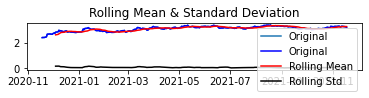

Results of Dickey-Fuller Test:
Test Statistic                  -3.789767
p-value                          0.003014
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.268523e+00
p-value                        4.057824e-08
#Lags Used                     5.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


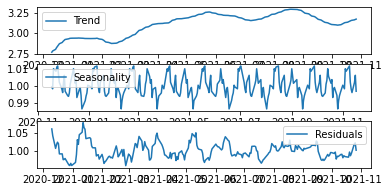

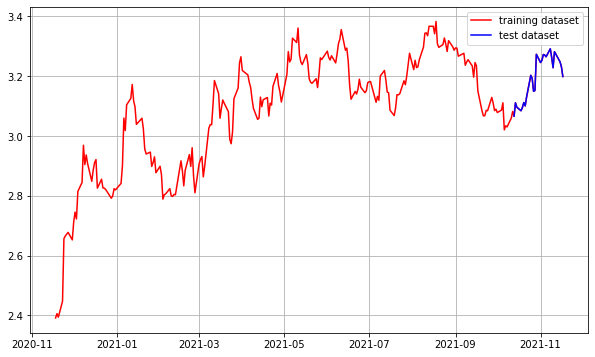

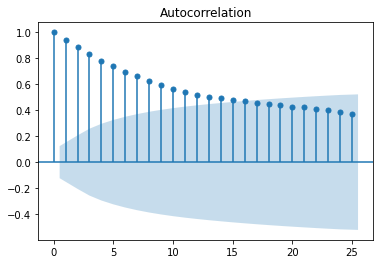

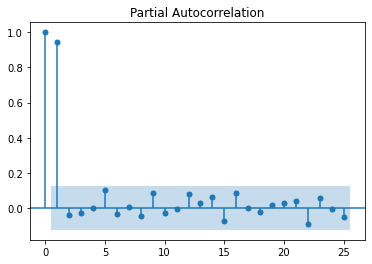

Results of Dickey-Fuller Test:
Test Statistic                -1.541464e+01
p-value                        3.090895e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


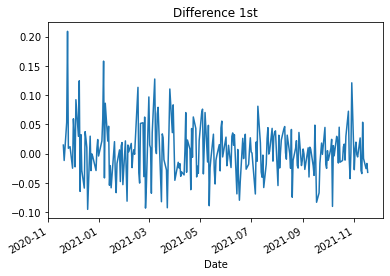

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 375.683
Method:                       css-mle   S.D. of innovations              0.046
Date:                Thu, 18 Nov 2021   AIC                           -745.366
Time:                        06:54:37   BIC                           -735.118
Sample:                             1   HQIC                          -741.230
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0031      0.003      0.979      0.328      -0.003       0.009
ar.L1.D.Close     0.0325      0.067      0.489      0.625      -0.098       0.163
                                    Root

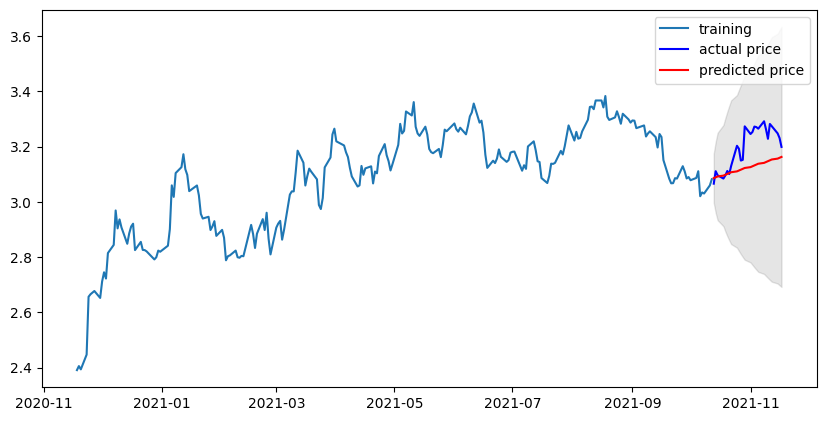

MSE:  4.958684535940691
MAE:  1.8051156318595454
RMSE:  2.2268103951483367
MAPE: 7.03%


In [108]:
stock_predict('USSC.csv')

> [정성적 분석]<br>
> 2020년 11월 부터 2021년 11월까지의 United States Steel Corporation stock 시계열 데이터를 정석적으로 분석했을 때,<br>
> Move average(MA)가 원본과 크게 다르지 않고, 이동표준편차도 크지 않음을 확인할 수 있다.<br>
> 이로써, 통계적 특정의 변화가 없고, 시간과 무관하게 일정한 값을 도출하는 안정적인 모습을 확인할 수 있다.<br>
> <br>
> [정량적 분석 Augmented Dicky-Fuller Test]<br>
> "주어진 시계열 데이터가 안정적이지 않다"는 귀무가설의 수치인 p-value는 0.003로, 0에 매우 가까운 결과를 보여주었다.<br>
이는, 귀무가설이 False임이 입증되었으며, 이에 "Residual의 시계열 데이터가 안정적이다"라는 대립가설을 채택한다.<br>
> <br>
> [시계열 분해 Time Series Decomposition]<br>
> 1. Trend - 원본 데이터의 변화의 큰 움직임(추세)에 맞춰 잘 표기한 모습을 보여주었다.<br>
> 2. seasonal - 원본 데이터의 변화를 일정한 패턴으로 움직이는 모습을 잘 표시한 모습을 보여주었다.<br>
> 3. residual - 원본 데이터의 변화의 작은 움직임(residual)에 맞춰 잘 표기한 모습을 보여주었다

> [Residual 안정성 확인]<br><br>
> "Residual의 시계열 데이터가 안정적이지 않다"는 귀무가설의 수치인 p-value는 4.057824e-08로, 0에 매우 가까운 결과를 보여주었다.<br>
> 이는, 귀무가설이 False임이 입증되었으며, 이에 "Residual의 시계열 데이터가 안정적이다"라는 대립가설을 채택한다.

> [Check ACF for p, q]<br>
> 현재값과 과거같이 일정하게 상관관계를 가지는 모습을 보여주었다.
<br><br>
> [Check PACF for p, q]<br>
> 미국철강회사 주식은 초기 2개월에 평균보다 매우 낮은 주가를 기록했으며 10개월간 횡보하는 모습을 보여주었다.<br>
이에, 데이터도 초기에 급등한 2개월은 이상치를 보여주었으나, 나머지 10개월 데이터는 준수한 관련성을 보여주었다.
<br><br>
> [Check difference for d]<br>
> 미국철강회사 주가가 급등한 2020년 2월~2020년 4월 이후 횡보하는 주가로 차분의 변화 주기가 잦고 변화량도 큰 모습을 확인할 수 있다.

> [모델 최종 결과]<br>
> 미국철강회사의 주가 예측 성능 수치인 MAPE의 정확률은 7.03%으로, 중장기적인 관점에서는 예측을 잘 했다고 생각한다.<br>
> 위 모델은 장기 추세선을 기준으로 큰 추세를 바탕으로 예측하도록 설계되었기에, 단기적인 급등까지는 예측하지 못했다.<br>
> 또한, 최근 주가가 모델이 예측한 상한선 바운드 범위내에 있음을 확인할 수 있다.<br>
> 미국 철강 회사는, 향후 2022년 원자력 전쟁의 핵심물자인 철강을 생산하는 회사로, 장기적으로 보았을때, 주가가 상승할것이라 생각된다.<br>
> 그러나, 최근 항만의 물류 적재로 인한 단기 악재로 하락할 가능성은 있다.

## 7.3 Roku, Inc. stock

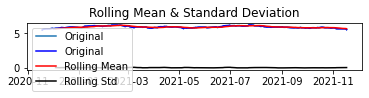

Results of Dickey-Fuller Test:
Test Statistic                  -1.752633
p-value                          0.404219
#Lags Used                       3.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.205237e+00
p-value                        5.678896e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


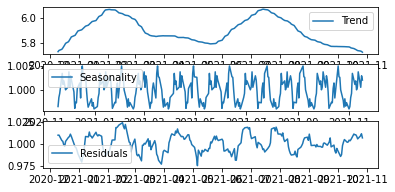

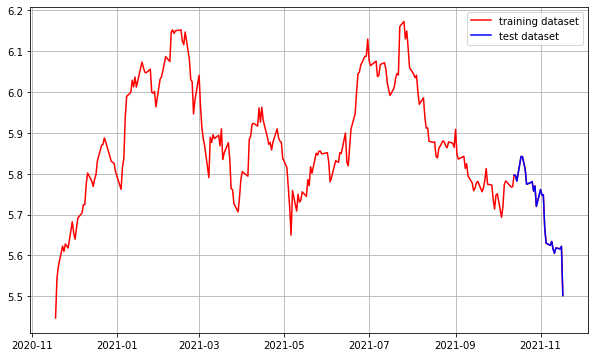

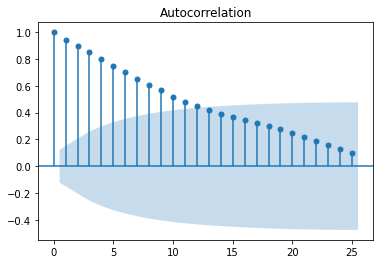

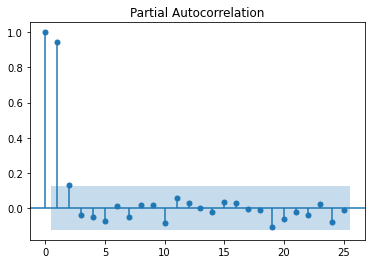

Results of Dickey-Fuller Test:
Test Statistic                -7.744305e+00
p-value                        1.041830e-11
#Lags Used                     2.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


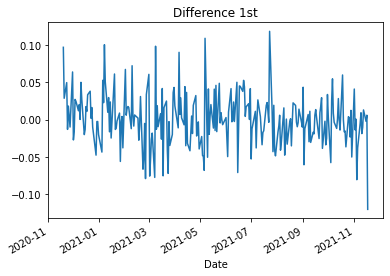

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 434.352
Method:                       css-mle   S.D. of innovations              0.035
Date:                Thu, 18 Nov 2021   AIC                           -862.704
Time:                        07:22:58   BIC                           -852.455
Sample:                             1   HQIC                          -858.567
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.002      0.624      0.533      -0.003       0.006
ar.L1.D.Close    -0.0305      0.068     -0.452      0.652      -0.163       0.102
                                    Root

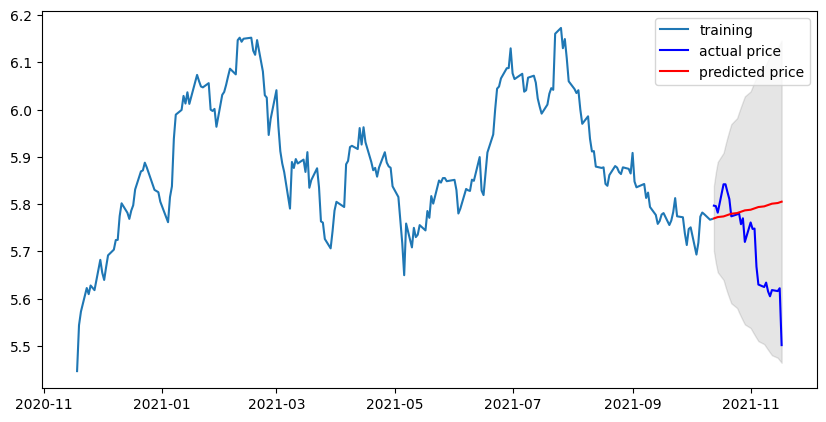

MSE:  1338.3795830812635
MAE:  27.72696951566272
RMSE:  36.5838705317147
MAPE: 9.82%


In [109]:
stock_predict('ROKU.csv')

> [정성적 분석]<br>
> 2020년 11월 부터 2021년 11월까지의 Roku, Inc 시계열 데이터를 정석적으로 분석했을 때,<br>
> Move average(MA)가 원본과 크게 다르지 않고, 이동표준편차도 크지 않음을 확인할 수 있다.<br>
> 이로써, 통계적 특정의 변화가 없고, 시간과 무관하게 일정한 값을 도출하는 안정적인 모습을 확인할 수 있다.<br>
> <br>
> [정량적 분석 Augmented Dicky-Fuller Test]<br>
> "주어진 시계열 데이터가 안정적이지 않다"는 귀무가설의 수치인 p-value는 0.4로, 중립 값인 모호안 결과를 보여주었다.<br>
> 이로써, 귀무가설도, 대립가설도 모두 입증되지 않는 모습을 보여주었다.<br>
> 그래도, 결정을 해야한다면 0.4는 1보다 0에 가깝기 때문에 대립가설을 선택할 것 같다.<br>
> PS. ROKU의 경우에는 코로나 특수로 호황을 맞이안 비디오 업종이다.<br>
> 2021년 하반기, 백신이 세계적으로 보급됨에 따라 오프라인 활동이 늘어나면서, 호황이 사그라드며, 주가도 하락하는 모습이다.<br>
> 때문에, 주가가 특수시기에 따란 단기 호황 호재로 오름에 따라 조정을 받는 자연스러운 시계열 데이터의 모습이라 생각한다.
> <br>
> [시계열 분해 Time Series Decomposition]<br>
> 1. Trend - 원본 데이터의 변화의 큰 움직임(추세)에 맞춰 잘 표기한 모습을 보여주었다.<br>
> 2. seasonal - 원본 데이터의 변화를 일정한 패턴으로 움직이는 모습을 잘 표시한 모습을 보여주었다.<br>
> 3. residual - 원본 데이터의 변화의 작은 움직임(residual)에 맞춰 잘 표기한 모습을 보여주었다

> [Residual 안정성 확인]<br><br>
> "Residual의 시계열 데이터가 안정적이지 않다"는 귀무가설의 수치인 p-value는 5.678896e-08로, 0에 매우 가까운 결과를 보여주었다.<br>
> 이는, 귀무가설이 False임이 입증되었으며, 이에 "Residual의 시계열 데이터가 안정적이다"라는 대립가설을 채택한다.

> [Check ACF for p, q]<br>
> 현재값과 과거같이 일정하게 상관관계를 가지는 모습을 보여주었다.
<br><br>
> [Check PACF for p, q]<br>
> ROKU 주식은 초기 2개월에 평균보다 매우 낮은 주가를 기록했으며 4개월간 고점 달성 후 조정을 받는 모습을 보여주었다.<br>
이에, 데이터도 초기에 급등한 2개월은 이상치를 보여주었으나, 나머지 10개월 데이터는 준수한 관련성을 보여주었다.
<br><br>
> [Check difference for d]<br>
> ROKU의 주가가 급등한 2020년 2월~2020년 3월 이후 고점 후 조정, 재 상승하는 주가로 차분의 변화 주기가 불안정한 모습을 확인할 수 있다.

> [모델 최종 결과]<br>
> ROKU의 주가 예측 성능 수치인 MAPE의 정확률은 9.82%으로, 중장기적인 관점에서는 예측을 잘 못했다고 생각한다.<br>
> 위 모델은 장기 추세선을 기준으로 큰 추세를 바탕으로 예측하도록 설계되었기에, 단기적인 급락까지는 예측하지 못했다.<br>
> 또한, 최근 주가가 모델이 예측한 하한선 바운드 범위내에 있음을 확인할 수 있다.<br>
> ROKU 회사와 유사 서비스를 제공하는, 넷플릭스, 아마존 서비스, 쿠팡 플레이가 선두를 달리고 있는 반면, ROKU 상대적으로 약한 모습을 보여주는 모습이다. 이에, 경쟁력 하락에 의한 주가가 하락하고 있는 상황이다.<br>
> 또한, 최근 미국의 초인플레이션으로 인한 주식시장의 거품을 규제하기 위한 테이퍼링이 곧 시행됨에 따라, 거품으로 올린 주가가 빠지는 모습을 보여주고 있다.

## 7.4 NVDA, Inc. stock

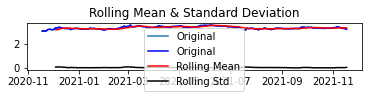

Results of Dickey-Fuller Test:
Test Statistic                  -3.219607
p-value                          0.018877
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -5.763910e+00
p-value                        5.589836e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


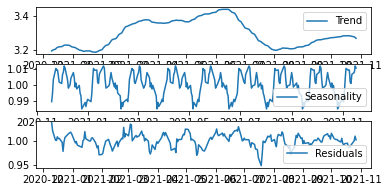

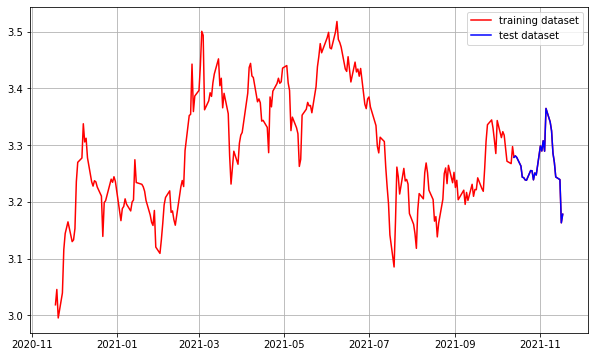

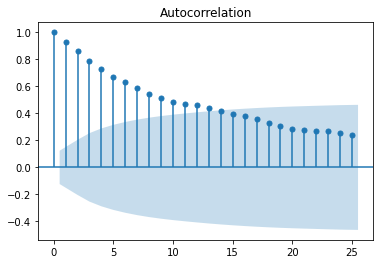

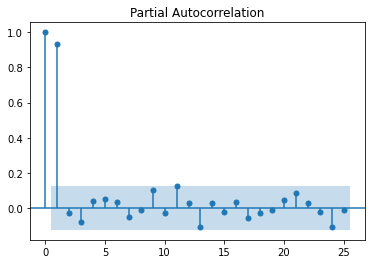

Results of Dickey-Fuller Test:
Test Statistic                -1.568323e+01
p-value                        1.463985e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


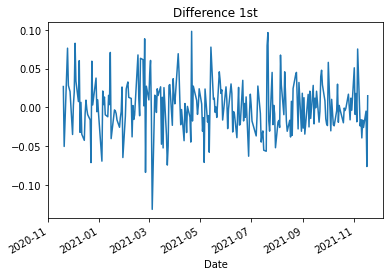

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 437.327
Method:                       css-mle   S.D. of innovations              0.035
Date:                Thu, 18 Nov 2021   AIC                           -868.654
Time:                        07:54:27   BIC                           -858.405
Sample:                             1   HQIC                          -864.517
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.002      0.529      0.597      -0.003       0.006
ar.L1.D.Close     0.0174      0.067      0.261      0.794      -0.113       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

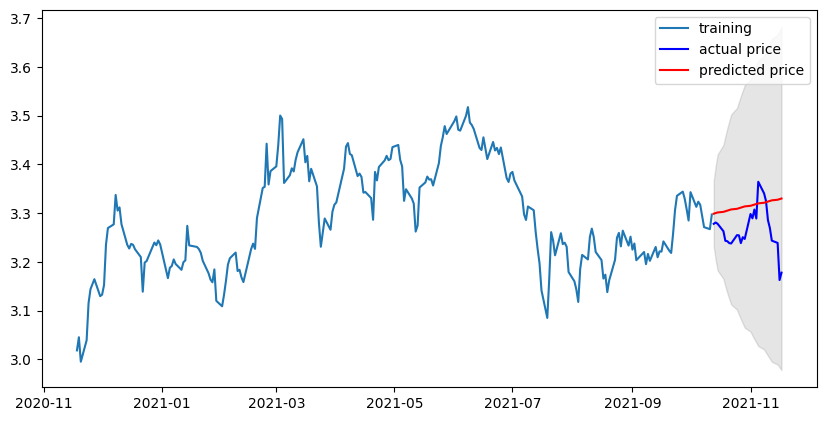

MSE:  3.030230513285443
MAE:  1.4382542556875093
RMSE:  1.7407557305048411
MAPE: 5.63%


In [112]:
stock_predict('NCLH.csv')

> [정성적 분석]<br>
> 2020년 11월 부터 2021년 11월까지의 NVDA, Inc 시계열 데이터를 정석적으로 분석했을 때,<br>
> Move average(MA)가 원본과 크게 다르지 않고, 이동표준편차도 크지 않음을 확인할 수 있다.<br>
> 이로써, 통계적 특정의 변화가 없고, 시간과 무관하게 일정한 값을 도출하는 안정적인 모습을 확인할 수 있다.<br>
> <br>
> [정량적 분석 Augmented Dicky-Fuller Test]<br>
> "주어진 시계열 데이터가 안정적이지 않다"는 귀무가설의 수치인 p-value는 0.01로, 0에 매우 가까운 결과를 보여주었다.<br>
> <br>
> [시계열 분해 Time Series Decomposition]<br>
> 1. Trend - 원본 데이터의 변화의 큰 움직임(추세)에 맞춰 잘 표기한 모습을 보여주었다.<br>
> 2. seasonal - 원본 데이터의 변화를 일정한 패턴으로 움직이는 모습을 잘 표시한 모습을 보여주었다.<br>
> 3. residual - 원본 데이터의 변화의 작은 움직임(residual)에 맞춰 잘 표기한 모습을 보여주었다

> [Residual 안정성 확인]<br><br>
> "Residual의 시계열 데이터가 안정적이지 않다"는 귀무가설의 수치인 p-value는 5.589836e-07로, 0에 매우 가까운 결과를 보여주었다.<br>
> 이는, 귀무가설이 False임이 입증되었으며, 이에 "Residual의 시계열 데이터가 안정적이다"라는 대립가설을 채택한다.

> [Check ACF for p, q]<br>
> 현재값과 과거같이 일정하게 상관관계를 가지는 모습을 보여주었다.
<br><br>
> [Check PACF for p, q]<br>
> NVDA의 주가는 초기 2개월에 평균보다 매우 낮은 주가를 기록했으며 4개월간 고점 달성 후 조정을 받는 모습을 보여주었다.<br>
이에, 데이터도 초기에 급등한 2개월은 이상치를 보여주었으나, 나머지 10개월 데이터는 범위 내에서 관련성을 보여주었다.
<br><br>
> [Check difference for d]<br>
> NVDA의 주가가 급등한 2020년 2월~2020년 3월 고점 후 조정, 4개월간 횡보 후, 하락 패턴으로로 차분의 변화 주기가 불안정한 모습을 확인할 수 있다.

> [모델 최종 결과]<br>
> NVDA의 주가 예측 성능 수치인 MAPE의 정확률은 5.63%으로, 단기(30일)이내는 좋은 예측이였으나, 90일 이상의 중장기적인 관점에서는 예측을 잘 못했다고 생각한다.<br>
> 위 모델은 장기 추세선을 기준으로 큰 추세를 바탕으로 예측하도록 설계되었기에, 단기적인 급락까지는 예측하지 못했다.<br>
> 또한, 최근 주가가 모델이 예측한 하한선 바운드 범위내에 있음을 확인할 수 있다.<br>
> NVDA 회사는 크루즈선 서비스 회사로, 관광을 주업인 회사이다. 그러나 코로나로 인해 관광 사업이 사장되며, 당사의 매출도 급락했다.<br>
> 이에, 주가가 급락을 넘어 폭락했으나, 금융시장에서 주식을 활용해 22억달러 이상의 현금 유동성을 확보하며, 재무 건전성을 개선했다.<br>
> 코로나 이후, 온라인 관광의 비중이 점차 증가함에 따라 향후, 주가는 하락세를 이어갈것으로 예상된다.

# 8. 최종 결과

> 본 프로젝트는 ARIMA 모델을 활용하여 테슬라, 미국 철강, ROKU, NVDA, 4개의 회사의 주가를 예측했다.<br>
> 실험에 대한 결과는 아래 표와 같다.

||테슬라|미국철강|ROKU|NVDA|
|-----|-----|-----|-----|-----|
|MAPE|18.04%|7.03%|9.82%|5.63%|

# 후기

> 이번 프로젝트는 외부 조건이 많은 주식 시장에 시계열 데이터로 정확한 예측이 가능할지 의문이 들었던 실습이었습니다.<br>
> 물론 주식에도 패턴이 존재하고 수많은 경제학자, 트레이너들이 주가의 패던과 주기, 트렌드를 정형화하여 이론을 정립하고 있습니다.<br>
> 그러나, 항상 외부 조건이 기존의 패던을 깨뜨리며 급등락, 흔히 차트를 찢는다고 표현하는 폭등과 같은 이상치는<br>
> 시계열 모델이 데이터를 학습함에 있어서 방해 요인이 되었으리라 생각됩니다.<br>
> 때문인지, ARIMA 모델은 작은 움직임과 차분의 폭이 많은 단기적인 관점에서의 예측에는 자주 실패하는 모습을 보여주었습니다.<br>
> 그러나, 180일 이상의 장기적인 관점은 꽤 준수한 적중률(60%)을 보여주었습니다.<br>
> 주식 시장에서 예측률 60%라는건 높은 적중률이라 생각됩니다.<br>